# Atividade 1 - Regress√£o Linear


## Introdu√ß√£o

<br>

<font size=4.25>

<p style='text-align: justify;'>
Os modelos de regress√£o linear, apesar de simples, s√£o suficientemente poderosos para a resolu√ß√£o de alguns problemas. Nesta atividade vamos explor√°-lo, elaborando-o do zero (<em> from scratch </em>). Para tal, utilizaremos a s√©rie hist√≥rica de medidas do n√∫mero de manchas solares observadas pelo <em> Atacama Large Milimiter/SubMilimiter Array </em> (ALMA). A abordagem do modelo de regress√£o linear deu-se atrav√©s de dois modos: com e sem a utiliza√ß√£o do termo de regulariza√ß√£o. Salienta-se que ao utilizar o termo de regulariza√ß√£o, os dados foram submetidos previamente a uma tranforma√ß√£o n√£o linear em uma estrutura semelhante a uma <em> Extreme Machine Learning </em> (ELM). Dito isso, esta atividade compreender√° as seguintes etapas:
</p>
    
1.<b>Tratamento pr√©vio</b>
    
- Defini√ß√£o de fun√ß√µes importantes
<br>   
- Divis√£o dos dados - Treinamento e Teste
    
2.<b> Regress√£o Linear</b> 
    
- Modelagem Matem√°tica
    
- Determina√ß√£o do Hiperpar√¢metro K
    
- Determina√ß√£o do vetor de par√¢metros w e comparativo com os dados de teste

3.<b> Regress√£o Linear com Regulariza√ß√£o (<em>Ridge Regression</em>)<br>

- Modelagem Matem√°tica
    
- Tratamento e Prepara√ß√£o dos Dados
    
- Estimativa de T e do par√¢metro de regulariza√ß√£o
    
- Determina√ß√£o  do vetor de par√¢metros w e comparativo com os dados de teste

    
<br>

    



In [25]:
import pandas as pd
import numpy as np
from numpy.linalg import inv
import matplotlib.pyplot as plt
from numpy.random import uniform
import os
import warnings

warnings.filterwarnings("ignore")

df = pd.read_csv('monthly-sunspots.csv', sep=";")

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3252 entries, 0 to 3251
Data columns (total 3 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   Unnamed: 0                         3252 non-null   int64  
 1   Date                               3252 non-null   object 
 2   Monthly Mean Total Sunspot Number  3252 non-null   float64
dtypes: float64(1), int64(1), object(1)
memory usage: 76.3+ KB


## 1. Tratamento Pr√©vio 

### 1.1 Definindo fun√ß√µes importantes

<br>

<font size=4.25>

<p style='text-align: justify;'>
Neste etapa do trabalho, criou-se duas fun√ß√µes: uma que tem por obejtivo o tratamento das datas no banco de dados, a fim de padroniz√°-las e torn√°-las do tipo DateTime, e a outra para a plotar o gr√°fico com os dados do problema.
</p>


In [26]:
def replace_data (x):
    
    if '/' in x:
    
        new_data = ''

        lista_char =x.split('/')

        new_data = lista_char[2]+'-'+lista_char[1]+'-'+lista_char[0]

        return new_data
    
    else: 
        
        return x

    
df['Date'] = df['Date'].apply(replace_data)

df['Date'] = pd.to_datetime(df['Date'], format='%Y-%m-%d')


def plot_graph(df, split_train_teste=False):

    plt.figure(figsize=(15,8))

    plt.plot(df['Date'], df['Monthly Mean Total Sunspot Number'])

    plt.xlabel('Time - Monthly', fontsize=12)

    plt.ylabel ('Monthly Mean Total Sunspot Number', fontsize=12)
    
    if split_train_teste:
        
        period=int(input('Qual √© o per√≠odo referente ao conjunto de testes (em meses):'))
        
        plt.axvline(x=df['Date'].max()-pd.DateOffset(months=period), color='r')
        
    plt.show()
    

### 1.2 Dividindo os dados - Treinamento e Teste

<br>

<font size=4.5>
<div style='text-align: justify;'>
Os dados utilizados foram divididos em duas partes, o conjunto de treinamento e o conjunto de teste. O conjunto de treinamento (denominado como <b>y_training_data</b>) compreende os dados observadors entre 1749 e 2009, enquanto o conjunto de testes √© composto dos dados observados entre 2010 e 2019 (denominado como <b>y_test</b>). A linha vermelha no gr√°fico abaixo  ilustra a divis√£o enre os dados de treinamento e os dados de teste. 
</p>

Qual √© o per√≠odo referente ao conjunto de testes (em meses):120


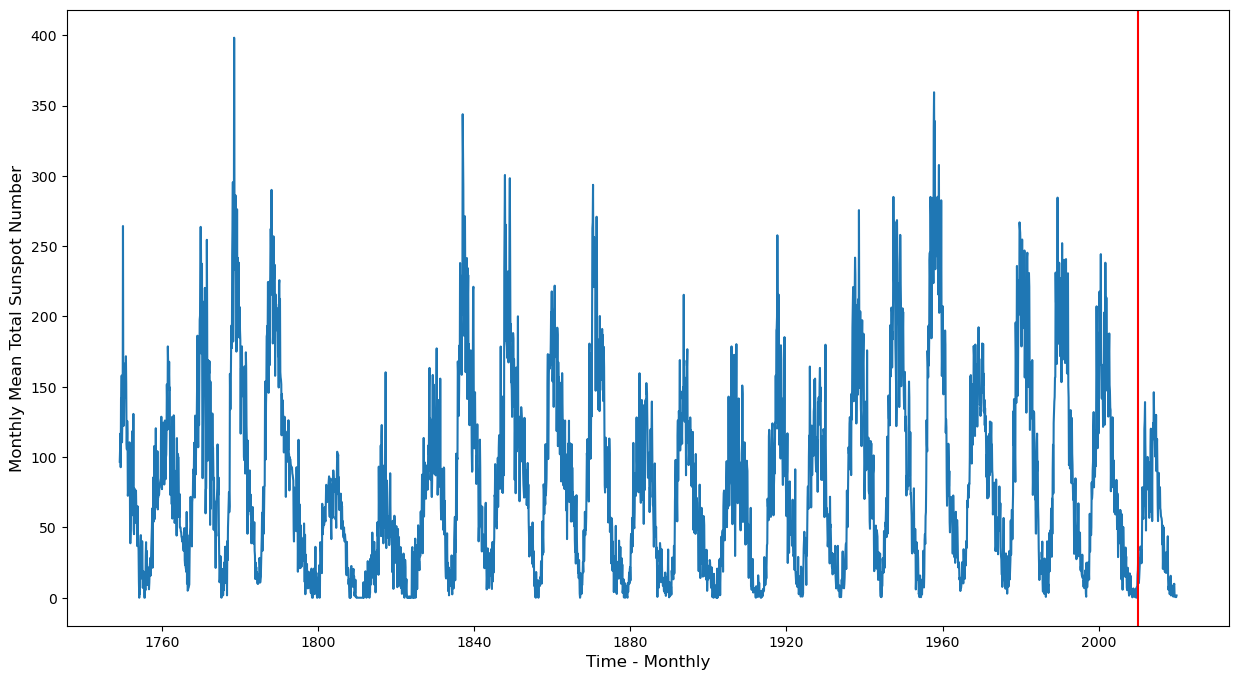

In [27]:
total_data_set = df.iloc[0:len(df),2].to_numpy()

y_training_data = df.iloc[0:len(df)-120,2].to_numpy()

y_test = df.iloc[(len(df)-120):,2].to_numpy()

plot_graph(df, split_train_teste=True)

## 2 - Regress√£o Linear 

### 2.1 Modelagem Matem√°tica <br>

<font size=4>

<p style='text-align: justify;'>
A defini√ß√£o do modelo matem√°tico pode ser realizada atrav√©s da solu√ß√£o de um problema de quadrados m√≠nimos lineares. Fundamentalmente este tipo de problema tem como objetivo aproximar solu√ß√µes de sistemas de equa√ß√µes lineares sobredeterminados, isto √©, sistemas que apresentam mais equa√ß√µes do que vari√°veis. Esta abordagem normalmente √© feita minimizando-se o quadrados dos erros em cada uma das equa√ß√µes. Matematicamente, o sistema linear sobredeterminado pode ser definido pela equa√ß√£o abaixo:     
</p>
    
<br>
  
\begin{equation} 
{A}{w} = Y 
\end{equation} 

<p style='text-align: justify;'> 
Em que A œµ $R^{N X K}$ s√£o os dados, com N>K ou geralmente N >>K. Naturalmente assume-se que o sistema √© incompat√≠vel e, portanto, deve-se definir um vetor <em> w </em> em que o res√≠duo do sistema, definido pela equa√ß√£o abaixo, seja o menor poss√≠vel.    
</p>
            
    
\begin{equation} 
{r(x)} = {Y}-Aw 
\end{equation} 
    
        
Assim sendo, a fun√ß√£o objetivo do problema de quadrados m√≠nimos consiste na minimiza√ß√£o da norma euclidiana do res√≠duo do sistema, conforme demonstra a equa√ß√£o a seguir:
    
\begin{equation} 
min{f_o(x)} =  \| Aw-y\|_{2}^{2} = \|r(x)\|_{2}^{2} = \sum_{i=1}^{m} r_{i}^{2}
\end{equation}
    
Onde $r_{i}$ √© a i-√©sima componente de r.  
    
    
Dado a configura√ß√£o da equa√ß√£o de res√≠duos, a minimiza√ß√£o da mesma indicar√° quais valores de w aproximam os valores de entrada com os de sa√≠da. 
    


In [28]:
def mean_squared_error (Y_data,y_hat):
    e2=np.square(y_hat-Y_data)
    MSE = (1/(len(Y_data)))*np.sum(e2)
    
    return MSE

<font size=4.5>

<p style='text-align: justify;'>    
O modelo matem√°tico de estima√ß√£o para realizar o mapeamento da equa√ß√£o de res√≠duos, previamente exposta, √© definido pela seguinte equa√ß√£o:
</p>   
    
\begin{equation} 
\hat{Y}(x) = –§(x)^{T}w
\end{equation}
    
Em que –§(x) œµ $R^{NXK+1}$. 
    
<br>    

<font size=4.5>

<p style='text-align: justify;'>    
A matriz e o vetor abaixo referem-se, respectivamente, aos dados das sequ√™ncias temporais X(n), somado de uma entrada fixa de valor unit√°rio que est√° relacionado a ${w_{o}}$, bem como ao vetor de par√¢metros w (o qual ser√° ajustado atrav√©s do aprendizado do modelo).
</p>
    
<br>  
    
    
$$ –§(x)^{T} =
\left [
\begin{matrix}
1 & X(n-1) & X(n-2) & X(n-3) & \cdots  & X(n-K)\\
1 & X(n) & X(n-1) & X(n-2) & \cdots  & X(n-K+1) \\
1 & X(n+1) & X(n) & X(n-1) & \cdots  & X(n-K+2) \\
1 & X(n+2) & X(n+1) & X(n) & \cdots & X(n-K+3) \\
1 & \vdots & \vdots & \vdots & \ddots & \vdots \\
1 & X(N) & \cdots & \cdots & \cdots & X(N-K) \\
\end{matrix}
\right ] 
$$

$$ w =
\left [
\begin{matrix}
{w}_0 \\
{w}_1  \\
{w}_2  \\
\vdots \\
\vdots \\
{w}_K \\
\end{matrix}
\right ] 
$$
 
<br>
  

<p style='text-align: justify;'>    
Da configura√ß√£o previamente citada, x(n) (correspondente a cada linha da matriz  –§(x)) √© o valor da s√©rie temporal no instante (discreto) n e o modelo constru√≠do deve reallizar um mapeamento do vetor entradas x(n) œµ $R^{K X 1}$, o qual √© formado por um subconjunto de K amostras passadas para uma sa√≠da <em >≈∑(n) </em>, que representa uma estimativa do valor futuro da s√©rie $x(n)^*$.    
</p>
   
<p style='text-align: justify;'>
No contexto previamente exposto, K √© definido como um hiperpar√¢metro do modelo. Isto √©, quantos valores K passados s√£o necess√°rios utilizar para que o previsto (K+1) seja o mais pr√≥ximo do real. 
</p>

<p style='text-align: justify;'>
A determina√ß√£o do valor de K foi definida a partir um processo de valida√ß√£o cruzada, do tipo <em> k-fold </em>. A valida√ß√£o cruzada consiste, a partir do conjunto de treinamento, na separa√ß√£o dos dados em um conjunto de treinamento - necess√°rio √† determina√ß√£o dos par√¢metros <em>w</em> - e um conjunto de valida√ß√£o. A partir deste, pode-se estimar a capacidade de generaliza√ß√£o do modelo, ou seja, est√° atrelado √† qualidade de aproxima√ß√£o produzida pelo modelo quando exposto a dados de entrada n√£o vistos durante o treinamento.
</p>
   
<p style='text-align: justify;'>
O m√©todo de <em>k-fold</em>, conforme demonstra a figura abaixo, consiste em dividir o conjunto de amostras dispon√≠veis para treinamento em k pastas e realizar k treinamentos, cada um considerando k-1 pastas para o ajuste dos par√¢metros e 1 pasta para valida√ß√£o.  
</p>
    
<img src="k-fold-ajustado.png">
    
    
A fun√ß√£o a seguir apresenta o processo de valida√ß√£o cruzada k-fold para o problema apresentado.

In [29]:
def create_kfold (k,initial_X_train,initial_Y_train,i):
    
    len_X_training = len(initial_X_train)
    n= len_X_training/k
    training_indices = np.arange(0, len_X_training)
    if i ==0:
            validation_indices = np.arange(0,n)
    else:
            validation_indices = np.arange(i*n,(i+1)*n)
                            
    validation_indices=validation_indices.astype(int)
    train_indices = np.delete(training_indices, validation_indices)
                    
    X_train = initial_X_train[train_indices]
    Y_train = initial_Y_train[train_indices]
                    
    X_validation = initial_X_train[validation_indices]
    Y_validation = initial_Y_train[validation_indices]
    
    return X_train, Y_train, X_validation, Y_validation


<font size=4.5>

<p style='text-align: justify;'>    
Por fim, √© necess√°rio determinar o processo de aprendizado, isto √©, de qual forma os pesos w ser√£o determinados. Tal como explicitado anteriormente, o sistema de equa√ß√µes √© sobredeterminado (mais equa√ß√µes do que vari√°veis), podendo portanto ser utilizado uma equa√ß√£o anal√≠tica (solu√ß√£o fechada) para a determina√ß√£o dos pesos, conhecida como equa√ß√£o normal:
</p>

    
\begin{equation} 
{w} = ({–§^{T}–§})^{-1}–§^{T}*y
\end{equation} 

In [30]:
def normal_equation (X_train, Y_train, param_reg):
    I_line = np.eye(X_train.shape[1])
    I_line[0,0]=0    
    X_trans = X_train.T
    reg_term = param_reg*I_line
    w=np.dot(inv(np.dot(X_trans, X_train)+reg_term), np.dot(X_trans, Y_train))
     
    return w

<font size=4.5>

<p style='text-align: justify;'>    
Antes da determina√ß√£o do hiperpar√¢metro K bem como dos par√¢metros necess√°rios √† minimiza√ß√£o da fun√ß√£o objetivo, √© necess√°rio definir uma fun√ß√£o que adeque as matrizes de entrada e sa√≠da de acordo com o n√∫mero de atrasos K.
</p>

In [31]:
def create_input_data (initial_train_data_set, K):
    train_data_size=len(initial_train_data_set)
    initial_X_train=np.zeros((train_data_size-K, K))
    initial_Y_train=np.zeros(train_data_size-K)
    
    for i in range(train_data_size-K):
        for j in range(K):
            initial_X_train[i, j] = initial_train_data_set[i+K-j-1]
            initial_Y_train[i] = initial_train_data_set[i+K]

    return initial_X_train, initial_Y_train


### 2.2 Determina√ß√£o do Hiperpar√¢metro K <br>


<font size=4.5>

<p style='text-align: justify;'>
O valor de K foi testado at√© 24. A partir de cada valor K, eram formados os diferentes conjuntos de valida√ß√£o e treinamento, com 4 composi√ß√µes distintas para cada valor de K, e o RMSE m√©dio (Erro Quadr√°tico M√©dio - Equa√ß√£o de Res√≠duos) era levantado. Da Figura abaixo, nota-se que o valor K que resultou no menor RMSE foi equivalente a 24.     
</p>

Text(0, 0.5, 'RMSE - Erro Quadr√°tico M√©dio')

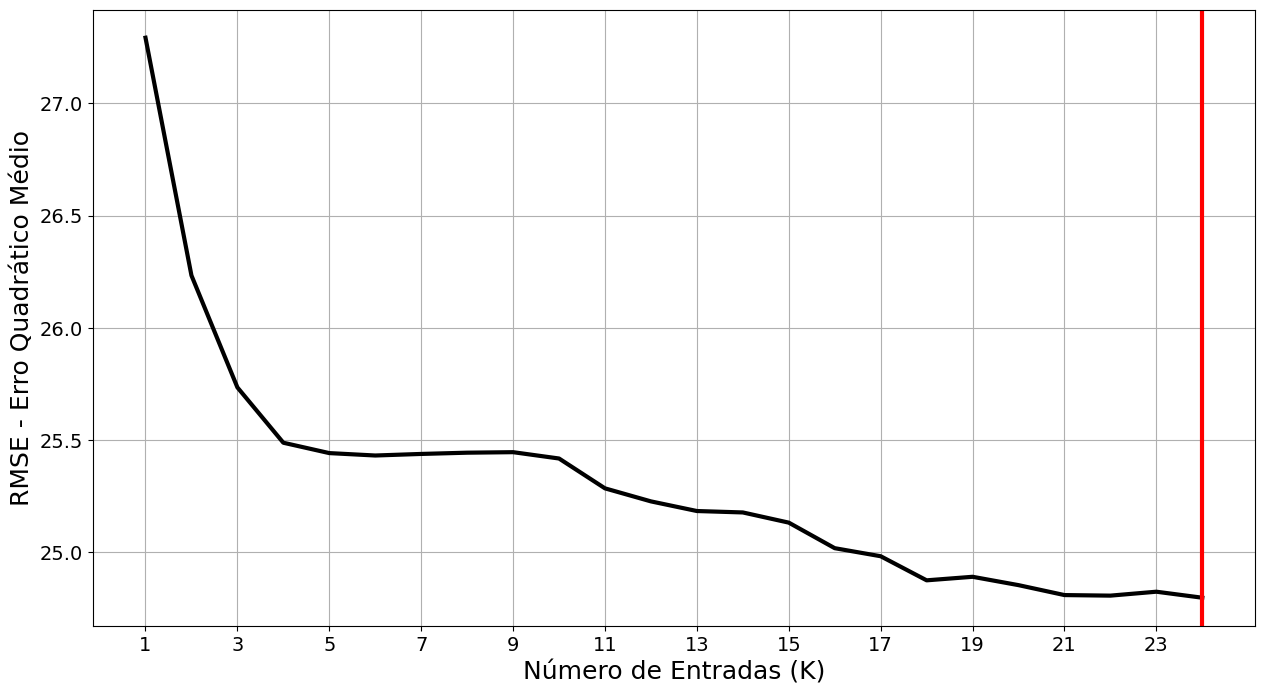

In [35]:
k=4
lista_RMSE=[]
lista_K = [x for x in range(1,25)]
for K in lista_K:
    lista=[]
    initial_X_train, initial_Y_train = create_input_data (y_training_data, K)
    for i in range (k):
       X_train, Y_train, X_validation, Y_validation = create_kfold(k,initial_X_train,initial_Y_train,i)
        
       X_train = np.concatenate((np.ones((len(X_train), 1)), X_train), axis=1)
       X_validation = np.concatenate((np.ones((len(X_validation), 1)), X_validation), axis=1)
     
       X_trans = X_train.T
       w = normal_equation(X_train, Y_train,0)
          
       y_hat = np.dot(X_validation,w)       
       MSE = mean_squared_error(Y_validation, y_hat)
   
       lista.append(MSE)
    lista_RMSE.append((np.sum(lista)/k)**0.5)

plt.figure(figsize=(15,8))
plt.plot(lista_K, lista_RMSE ,color="black", linewidth=3)
plt.xticks([x for x in range(1,25,2)],fontsize=14)
plt.yticks(fontsize=14)
plt.axvline(np.argmin(np.array(lista_RMSE))+1, color='red', linewidth=3)
plt.grid()
plt.xlabel("N√∫mero de Entradas (K)", fontsize=18)
plt.ylabel("RMSE - Erro Quadr√°tico M√©dio",fontsize=18)


### 2.3 Determinando o vetor de par√¢metros w e comparativo com os dados de Teste <br>


<font size=4.5>

<p style='text-align: justify;'>
    Com o hiperpar√¢metro K determinado, √© poss√≠vel obter o vetor de par√¢metros <em> w </em> que haver√° a minimiza√ß√£o da equa√ß√£o de res√≠duos (fun√ß√£o objetivo do problema de m√≠nimos quadrados). Para tal, √© necess√°rio determinar o vetor de par√¢metros <em> w </em>, a partir da equa√ß√£o normal, junto a todo o conjunto de treinamento. 

<p style='text-align: justify;'>
Conforme ilustra a figura abaixo, os valores preditos pelo modelo obtido s√£o semelhantes aos dados de teste, compeendendo uma parcela consider√°vel das sazonlidades presentes no cojuntos de dados avaliados.
</p>

Text(0, 0.5, 'N√∫mero M√©dio de Manchas Solares')

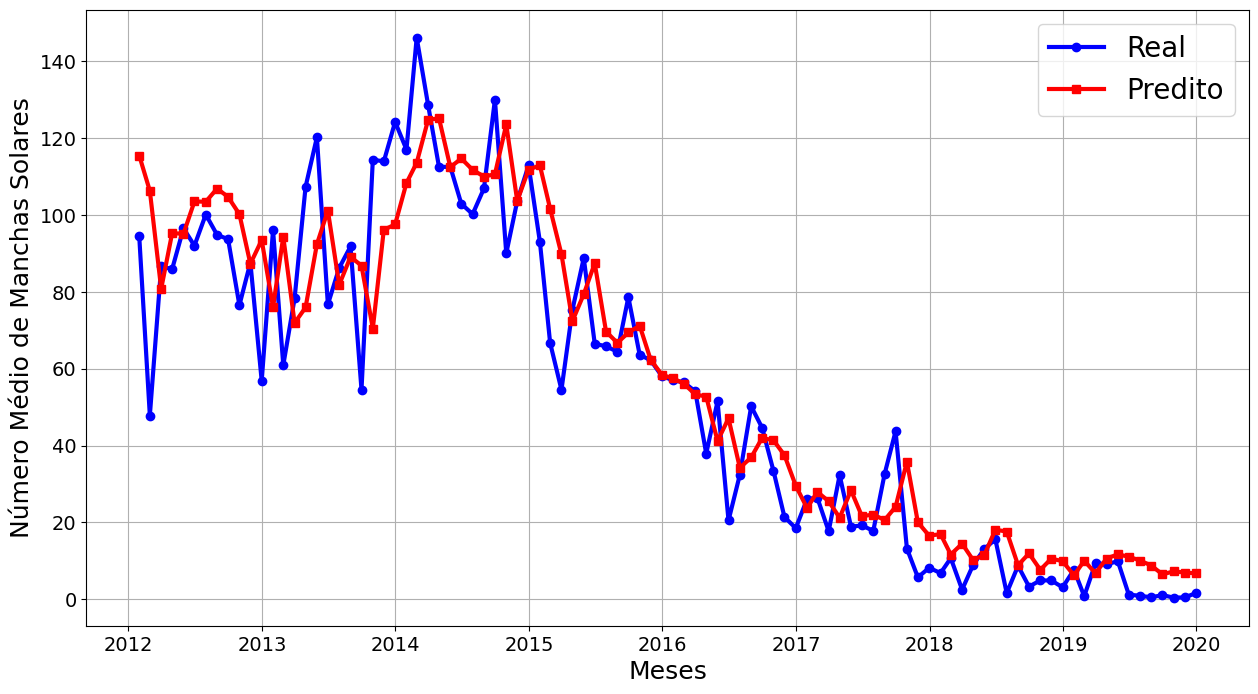

In [36]:
K_min = np.argmin(lista_RMSE)+1

X_train_final, Y_train_final = create_input_data (y_training_data, K_min)
vetor_bias=np.ones((len(X_train_final),1))
X_train_final = np.concatenate((vetor_bias, X_train_final), axis=1)

X_train_final_trans = X_train_final.T

w_teste = normal_equation(X_train_final, Y_train_final,0)

X_teste, Y_teste = create_input_data (y_test, K_min)
vetor_bias=np.ones((len(X_teste),1))
X_teste = np.concatenate((vetor_bias, X_teste), axis=1) 

y_hat_teste=np.dot(X_teste,w_teste)

new_df = df[df['Date']>=df['Date'].max()-pd.DateOffset(months=120-K_min-1)]

plt.figure(figsize=(15,8))
plt.plot(new_df['Date'],Y_teste ,color="blue", label="Real", linewidth=3, marker="o")
plt.plot(new_df['Date'],y_hat_teste, color="red", label="Predito", linewidth=3, marker="s")
plt.legend(fontsize=20)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.grid()
plt.xlabel("Meses", fontsize=18)
plt.ylabel("N√∫mero M√©dio de Manchas Solares",fontsize=18)

## 3 - Regress√£o Linear com Regulariza√ß√£o (Ridge Regression)

    
### 3.1 Modelagem Matem√°tica <br>
  

<font size=4.5>

<p style='text-align: justify;'>
Nesta parte da atividade avaliou-se o comportameno do modelo matem√°tico de estima√ß√£o a partir da adi√ß√£o de um termo de regulariza√ß√£o. Assim, a equa√ß√£o de res√≠duos (fun√ß√£o objetivo do problema), previamente exposta, adquire um configura√ß√£o equivalente a da equa√ß√£o abaixo. 
</p>   
    
\begin{equation} 
min f_{0}(x) = \| Aw-y\|_{2}^{2} + Œª\|w\|_{2}^{2}
\end{equation}
 
<br>
<font size=4.5>    
    
<p style='text-align: justify;'>
Conforme pode ser visto na equa√ß√£o acima, houve a introdu√ß√£o de um termo de penaliza√ß√£o proporcional √† norma euclidiana do vetor de par√¢metros/pesos (<em>w</em>). Com isso, em vez de minimizar a somente o erro quadr√°tico, minimiza-se a soma entre o erro quadr√°tico e a norma euclidiana do vetor de par√¢metros.
</p> 
    
<p style='text-align: justify;'>
A utiliza√ß√£o da regulariza√ß√£o tem como objetivo a redu√ß√£o da possibilidade de ocorr√™ncia de sobre ajuste (<em>overfitting</em>), melhorando assim a capacidade de generaliza√ß√£o do modelo e, portanto, o seu desempenho efetivo. A introdu√ß√£o do termo de regulariz√ß√£o √© uma forma impedir que a a diferen√ßa entre os valoes preditos e reais alcancem o seu menor valor poss√≠vel. Conforme apresenta a figura abaixo, o algoritmo ir√° encontrar um ponto de equil√≠brio entre a equa√ß√£o de res√≠duos ($ \| Aw-y\|_{2}^{2}$) e o termo de penalidade ($\|w\|_{2}^{2}$).
</p>   
    
<img src="regularization.png">
         
<p style='text-align: justify;'>
    Conforme pode ser visto na equa√ß√£o abaixo, a defini√ß√£o dos valores que comp√µem o vetor <em> w </em> (pesos) para este caso tamb√©m pode se dar atrav√©s de uma solu√ß√£o fehada, semelhante √†quela obtida para o caso sem a adi√ß√£o do termo de regulariza√ß√£o.
</p>  

    
\begin{equation} 
w = (–§^{T}–§ + ŒªI')^{-1}–§^{T}y
\end{equation}

    
onde: $$ I' =
\left [
\begin{matrix}
0 & 0 & \cdots & 0\\
0 & 1 &  \cdots & 0 \\
\vdots & \vdots  & \ddots & 0 \\
0 & \vdots & \vdots &  1\\
\end{matrix}
\right ] 
$$

Ressalta-se que embora a matriz –§ n√£o possua posto completo, a inversa sempre exisitir√° por conta da adi√ß√£o do termo de regulariza√ß√£o √† diagonal principal.
    
    
<br>
    
<font size=4.5>

<p style='text-align: justify;'>
Al√©m da regulariza√ß√£o como fator novo nesta etapa da modelagem, o modelo de predi√ß√£o linear √© alimentado por valores de entrada obtidos a partir de tranforma√ß√µes n√£o lineares do vetor X(n). Isto √©, os atributos que s√£o efetivamente combinados linearmente s√£o produtos de mapeamentos n√£o lineares dos atrasos das s√©ries presentes no vetor original X(n). Assim, gerou-se T atributos transformados a partir do equacionamento abaixo:   
</p>   

\begin{equation} 
X'_{k}(n) = tanh(\beta_{k}^{T}x(n))
\end{equation} 

<p style='text-align: justify;'>
para  k=1,...,T, n=1,...,N. Os vetores $\beta_{k}$ tem seus elementos gerados aleatoriamente de acordo com uma distribui√ß√£o uniforme.
</p> 
    
<br>
    
<font size=4.5>

<p style='text-align: justify;'>    
Desta forma, o modelo de estima√ß√£o ir√° adquirir uma configura√ß√£o semelhante ao equacionamento abaixo:
</p>   
            
\begin{equation} 
\hat{Y}(x) = X'_{k}(n)w_{T} = tanh(\beta_{k}^{T}x(n))*w_{T}
\end{equation}
    
    
<p style='text-align: justify;'>
Embora as entradas do modelo s√£o resultados de transforma√ß√µes n√£o lineares, a solu√ß√£o fechada para a determina√ß√£o dos par√¢metros w continua sendo v√°lida uma vez que a linearidade est√° sendo preservada entre os par√¢metros/pesos (<em>w</em>) do modelo proposto. Al√©m disso, a estrutura explorada para a modelagem desta parte do exerc√≠cio √© correspondente a uma rede neural conhecida como <em> extreme machine learning </em> (ELM).
</p>     
   

### 3.2 Tratamento  e Prepara√ß√£o dos Dados <br>

<font size=4.5>

<p style='text-align: justify;'>
Antes de realizar as transforma√ß√µes lineares propriamente ditas, as seguintes premissas foram levadas em conta:
</p>
    
    
- Normaliza√ß√£o dos dados: Tem-se a necessidade disto a fim de que o conjunto de dados, quando combinados linearmente com os par√¢metros do modelo (peso), n√£o sejam compostos essencialmente de valores saturados (0 ou 1).

* Delimita√ß√£o dos valores de $\beta_{k}\$: Tais  valores foram delimitados entre 0 e 0.3 a fim tamb√©m de n√£o promover as satura√ß√µes dos dados.     

    
<p style='text-align: justify;'>
Conforme pode ser visto na Figura abaixo, a fun√ß√£o tangente hiperb√≥lico apresenta satura√ß√µes para valores acima de 2.4, assim, √© necess√°rio que os valores de ùõΩ quando combinados linearmente com os valores de X(n) n√£o resultem em valores acima de 2.4 e que, portanto, o conjunto de dados n√£o seja essencialmente composto por valores saturados.  
</p>

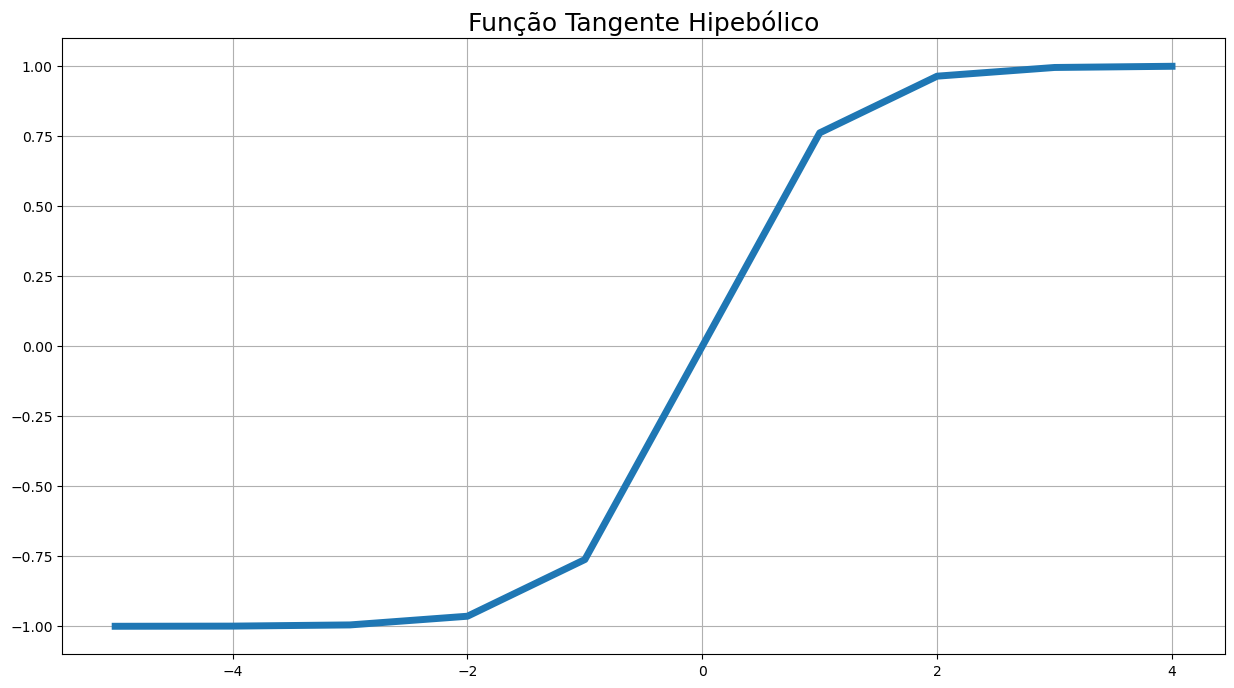

In [37]:
plt.figure(figsize=(15,8))

plt.plot([i for i in range(-5,5,1)],np.tanh([i for i in range(-5,5,1)]), linewidth=5)

plt.title ("Fun√ß√£o Tangente Hipeb√≥lico", fontsize=18)

plt.grid()

plt.show()

<font size=4>

<p style='text-align: justify;'>
A transforma√ß√µes n√£o lineares dos dados foi feita considerando um K=8 (n√∫mero de atrasos presentes no vetor X(n)). Al√©m disso, os dados de treinamento e teste foram divididos tal como na primeira etapa do problema. 
</p>

In [38]:
## Estabelecendo Par√¢metros Iniciais
K_entrada = 8
k_fold=4
T_lim=100
n_param_reg=200

## Normaliza√ß√£o dos dados e separa√ß√£o dos dados de treinamento e teste
min_data = min(total_data_set)
data_interval = max(total_data_set)-min_data
norm_data_set = (total_data_set-min_data)/data_interval
train_data_norm = norm_data_set[0:len(total_data_set)-120]
test_data_norm = norm_data_set[(len(total_data_set)-120):]
w_k = uniform(0, 0.3, size=(K_entrada, T_lim))

## Determinando 
X_train_data_norm, Y_train_data_norm = create_input_data (train_data_norm, K_entrada)
X_test_data_norm, Y_test_data_norm = create_input_data (test_data_norm, K_entrada)

#Aplicando as transforma√ß√µes n√£o-lineares
final_X_train_data=np.tanh(np.dot(X_train_data_norm,w_k))
final_X_test_data =np.tanh(np.dot(X_test_data_norm,w_k))

### 3.3 Estimativa de  T e do par√¢metro de regulariza√ß√£o ($\lambda$)<br>

<font size=4.5>

<p style='text-align: justify;'>
A fim de levantar o valor de T atributos transformados (variando entre 0 e 100) que  implica no menor RMSE, aplicou-se o m√©todo de valida√ß√£o cruzada k-fold (tal como feito na primeira etapa deste exerc√≠cio). Al√©m da determina√ß√£o do valor de T, √© tamb√©m necess√°rio encontrar o valor do par√¢metro de regulariza√ß√£o ($\lambda$) para que a condi√ß√£o de minimiza√ß√£o da fun√ß√£o obejtivo tamb√©m seja satisfeita. Assim sendo, a cada valor de T entradas do modelo eram testados valores de ($\lambda$) entre  0 e 1 com um passo equivalente a 0.005. Ressalta-se os valores de RMSE foram levantados a partir da desnormaliza√ß√£o dos dados, isto √©, no dom√≠nio original do problema (fun√ß√£o abaixo).
</p>

In [39]:
def inver_norm (data,min_value, interval):
    final_value=((interval)*data)+min_value
    return final_value

In [40]:
matriz_MSE_final = np.zeros((T_lim,n_param_reg))

for T in range(1,T_lim+1):
    contador=0
    X_train=final_X_train_data[:,0:T] 
    for param_reg in np.arange(0,1,0.005):
        contador+=1
        lista_MSE=[]
        
        for i in range(k_fold):
            final_X_train, final_Y_train, final_X_validation, final_Y_validation = create_kfold(k_fold,X_train,Y_train_data_norm, i)
            
            final_X_train = np.concatenate((np.ones((len(final_X_train), 1)), final_X_train), axis=1)
            final_X_validation = np.concatenate((np.ones((len(final_X_validation), 1)), final_X_validation), axis=1)
               
            w=normal_equation(final_X_train,final_Y_train, param_reg)
            
            y_hat = np.dot(final_X_validation, w)
            y_hat_desnorm = inver_norm(y_hat,min_data,data_interval)
            final_Y_validation_desnorm=inver_norm(final_Y_validation,min_data,data_interval)
            
            MSE = mean_squared_error (final_Y_validation_desnorm, y_hat_desnorm) 
            lista_MSE.append(MSE)
            
        matriz_MSE_final[T-1,contador-1]=(1/k_fold)*np.sum(lista_MSE)
        
rms_K_val = np.sqrt(matriz_MSE_final)

matriz_min=np.zeros(rms_K_val.shape[0])
for i in range (len(rms_K_val)):
    matriz_min[i]=np.min(rms_K_val[i,:]) 

<font size=4>

<p style='text-align: justify;'>
Ap√≥s o valor de T ser testado no intervalo citado bem como para diferentes valores de $\lambda$, constatou-se que o valor de T que resultava no menor RMSE durante o processo de valida√ß√£o cruzada foi equivalente a 12 (linha vermelha no gr√°fico abaixo). Nota-se da mesma figura que os valores de RMSE s√£o bastante similres a partir de T igual 9 (linha azul pontilhada do gr√°fico), indicando que a constru√ß√£o do modelo pode ser feita baseada em valores de T acima desse limiar sem que o desempenho do modelo seja efetivamente afetado.

Text(0, 0.5, 'RMSE')

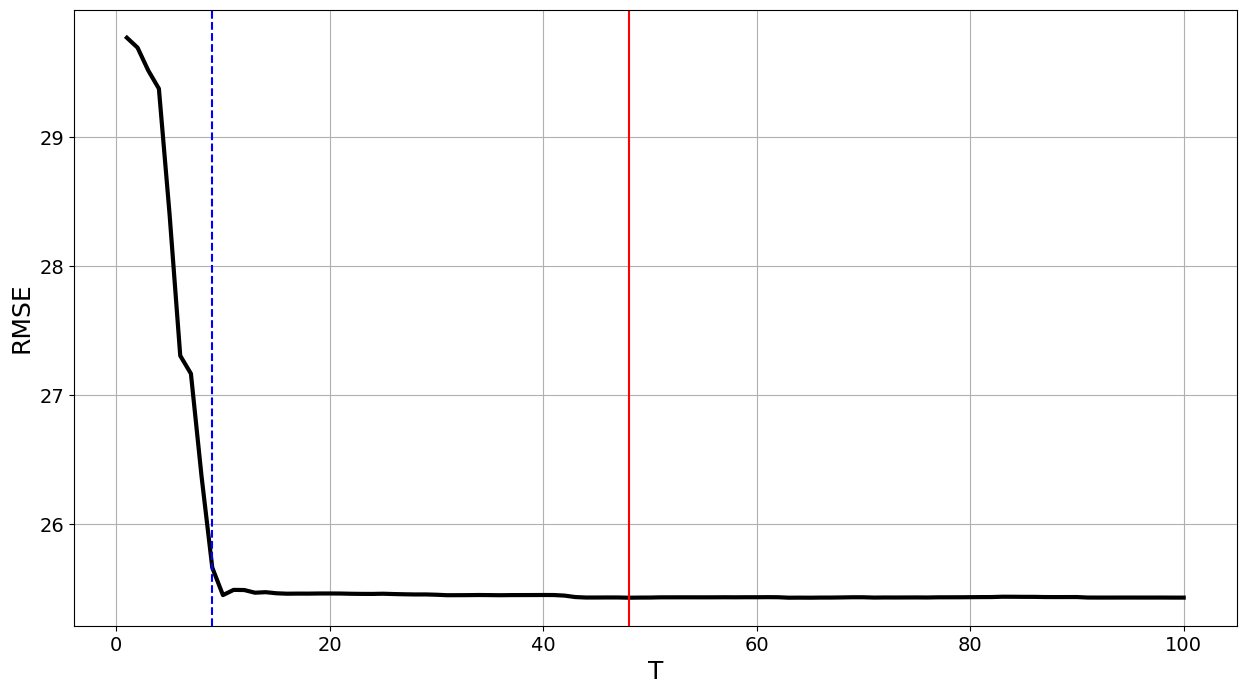

In [42]:
fig_A=plt.figure(figsize=(15,8))
plt.plot([x for x in range(1,101,1)], matriz_min ,color="black", linewidth=3)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.axvline(np.argmin(matriz_min)+1, color='red')
plt.axvline(9, color='blue',linestyle='dashed')
plt.grid()
plt.xlabel("T", fontsize=18)
plt.ylabel("RMSE",fontsize=18)

<font size=4>

<p style='text-align: justify;'>
No que diz respeito √† sele√ß√£o do valor de $\lambda$ (par√¢metro de regulariza√ß√£o), esta foi baseada no gr√°fico da Figura abaixo. Neste gr√°fico foram levantados os valores de $\lambda$ que resultaram nos menores RMSEs. Como √© poss√≠vel observar, atrav√©s da linha vermelha, o valor de lambda encontrado, para T=12, √© igual a zero. 
</p>

Text(0.5, 0, 'T')

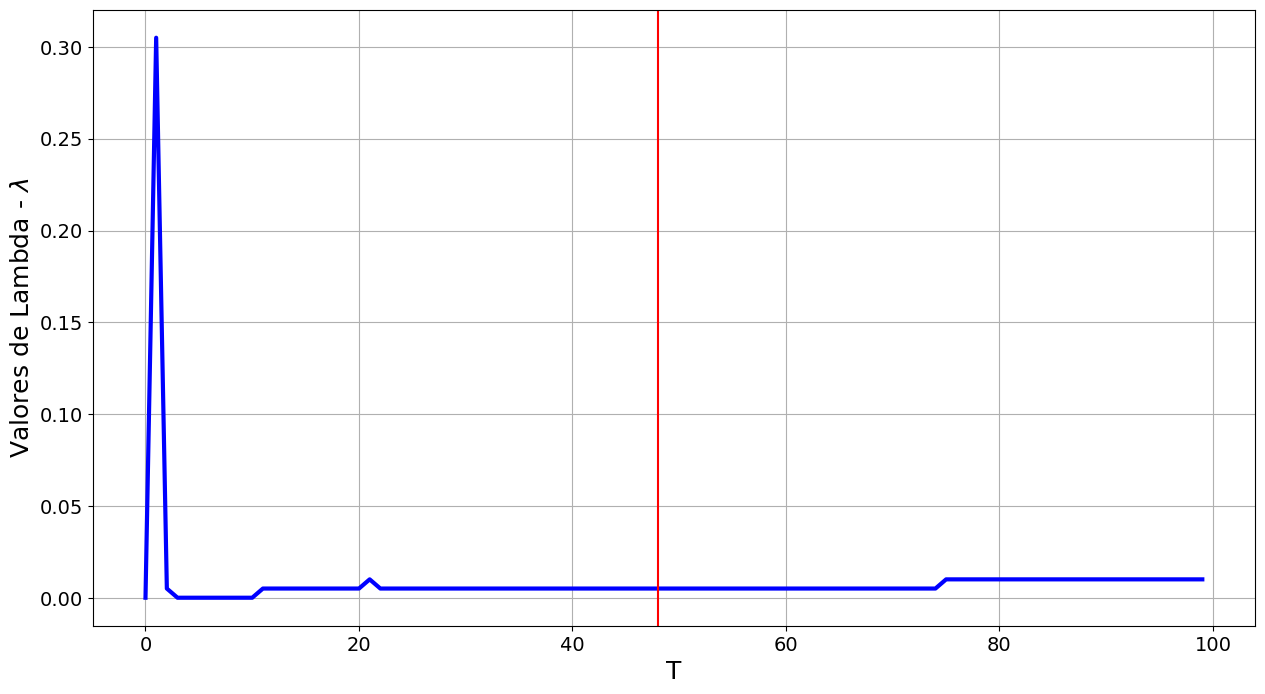

In [47]:
lista_lambda=[]
for i in (np.argmin(rms_K_val, axis=1)):
    A=np.arange(0,1,0.005)
    lista_lambda.append(A[i])
    
plt.figure(figsize=(15,8))
plt.plot(lista_lambda ,color="blue", linewidth=3)
plt.axvline(np.argmin(matriz_min)+1, color='red')
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.grid()
plt.ylabel("Valores de Lambda - $\lambda$", fontsize=18)
plt.xlabel("T", fontsize=18)

### 3.4 Determinando os valores dos par√¢metros <em> w </em> (pesos) e comparativo com os dados de teste<br>

<font size=4.5>

<p style='text-align: justify;'>
Com ambos os valores de $\lambda$ e T em m√£os levantou-se os valores do vetor de par√¢metros w junto ao conjunto de treinamento como um todo (treinamento + valida√ß√£o).
</p>
   
<br>
    
<font size=4.5>

<p style='text-align: justify;'>   
    A partir dos valores de <em> w </em>, foi realizado o comparativo entre os dados de teste e aqueles obtidos pelo modelo. Conforme pode ser visto na Figura abaixo e a exemplo da primeira parte do exerc√≠cio, o modelo de estima√ß√£o conseguiu compreender as sazonalidades presentes nos dados de testes. 
</p>

Text(0, 0.5, 'Monthly Mean Total Sunspot Number')

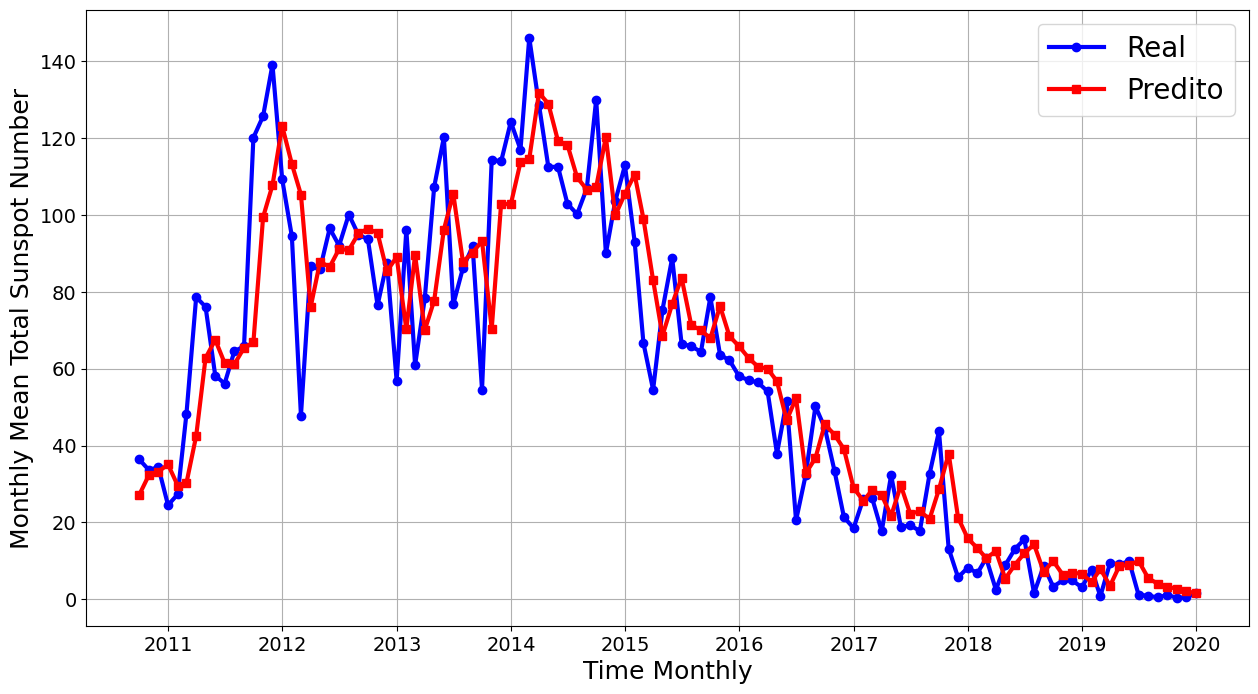

In [119]:
T_otm=np.argmin(matriz_min)+1
lambda_otm=lista_lambda[T_otm-1]

NL_train_data = final_X_train_data[:,0:T_otm]
vetor_bias=np.ones((len(NL_train_data),1))
NL_train_data = np.concatenate((vetor_bias, NL_train_data), axis=1)

w_train = normal_equation (NL_train_data,Y_train_data_norm,lambda_otm)

y_hat_train=np.dot(NL_train_data,w_train)
y_hat_desnorm_train = inver_norm(y_hat_train,min_data,data_interval)
NL_Y_train_desnorm=inver_norm(Y_train_data_norm,min_data,data_interval)


NL_test_data = final_X_test_data[:,0:T_otm]

vetor_bias=np.ones((len(NL_test_data),1))
NL_test_data = np.concatenate((vetor_bias, NL_test_data), axis=1) 

y_hat_teste=np.dot(NL_test_data,w_train)

y_hat_teste_desnorm = inver_norm(y_hat_teste, min_data, data_interval)
Y_test_data_desnorm = inver_norm(Y_test_data_norm, min_data, data_interval)


new_df = df[df['Date']>=df['Date'].max()-pd.DateOffset(months=120-8-1)]

fig=plt.figure(figsize=(15,8))
plt.plot(new_df['Date'],Y_test_data_desnorm ,color="blue", label="Real", linewidth=3, marker="o")
plt.plot(new_df['Date'],y_hat_teste_desnorm, color="red", label="Predito", linewidth=3, marker="s")
plt.legend(fontsize=20)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.grid()
plt.xlabel("Time Monthly", fontsize=18)
plt.ylabel("Monthly Mean Total Sunspot Number",fontsize=18)
